In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import os
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import pdist, squareform

In [2]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

In [3]:
file = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/male_rarefied_interpolated_feces.csv'

df = pd.read_csv(file, index_col = [0])
df = df.sort_index()
taxonomy = pd.read_csv('taxonomy/taxonomy.tsv', sep = '\t')
#filter
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, 0.9)

In [4]:
taxonomy[['o', 'p', 'c', 'o', 'f', 'g', 's']] = taxonomy['Taxon'].str.split('; ', expand=True)

In [5]:
dictionary = dict(zip(taxonomy['Feature ID'], taxonomy['o']))
df_filtered_order = df_filtered.rename(columns=dictionary).T.reset_index()
df_filtered_order = df_filtered_order.groupby(by=['index']).sum().T

#### LOG CONTRAST VARIANCE MATRIX

In [6]:
df_filtered_order = df_filtered_order + 0.01
df_filtered_order_sum = df_filtered_order.div(df_filtered_order.sum(axis=1), axis=0)

In [7]:
def plot_logcontrast_variance_matrix(df, title=None):
    
    VAR1 = []
    VAR2 = []
    VARIANCE = []
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            pairwise_variance = np.var(np.log(df.iloc[:, i]/df.iloc[:, j]))
            VAR1.append(df.iloc[:, i].name)
            VAR2.append(df.iloc[:, j].name)
            VARIANCE.append(pairwise_variance)

    VARIANCE_DF = pd.DataFrame(list(zip(VAR1, VAR2, VARIANCE)), columns = ['VAR1', 'VAR2', 'VARIANCE'])
    VARIANCE_MATRIX = VARIANCE_DF.pivot(index='VAR1', columns='VAR2', values='VARIANCE')

    plt.figure(figsize = [10, 10])
    sns.heatmap(VARIANCE_MATRIX, cmap='Blues', linewidths = .9, annot=True)
    plt.show()

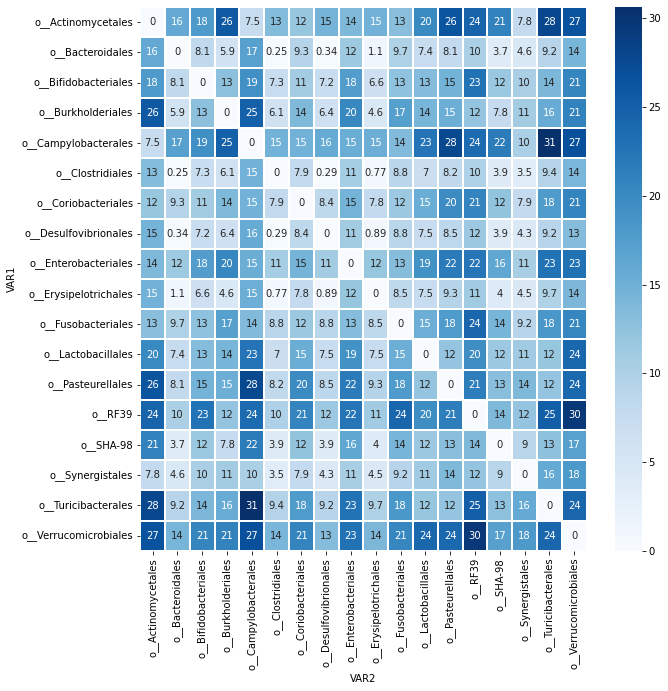

In [8]:
plot_logcontrast_variance_matrix(df_filtered_order_sum)

#### CLR VARIANCE MATRIX

In [9]:
clr_transformer = CLRTransformer(is_pseudo_global=True, axis=1)
CLR_DF = clr_transformer.fit_transform(df_filtered_order_sum)

In [10]:
def plot_clr_covariance_matrix(df, title=None):
    
    CLR_COVARIANCE_MATRIX = CLR_DF.cov()

    plt.figure(figsize = [10, 10])
    sns.heatmap(CLR_COVARIANCE_MATRIX, cmap='vlag', linewidths = .9, center = 0.0, annot=True)
    plt.show()
    return 

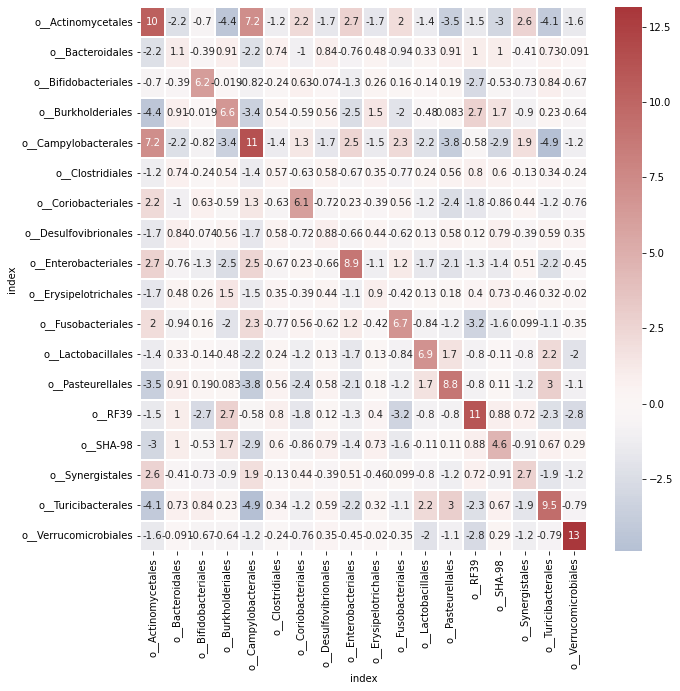

In [11]:
plot_clr_covariance_matrix(CLR_DF)

## PCA 

In [95]:
def plot_pca(df, columns, title=None):
    
    pca = PCA()
    x_new = pca.fit_transform(df)
    score = x_new[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])
    timesteps = range(len(df))#222 * [0] + 221*[1]
    labels = columns

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig = plt.figure(figsize=(15, 15))

    #plt.scatter(xs * scalex,ys * scaley)#, c = y)
    sns.scatterplot(x = xs * scalex, y = ys * scaley, alpha = .6, color = 'orange', edgecolor = 'black', hue = timesteps, s=50)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize = 12)

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

    plt.tight_layout()
    plt.show()
    #plt.savefig('PCA_donorA_clr.png')

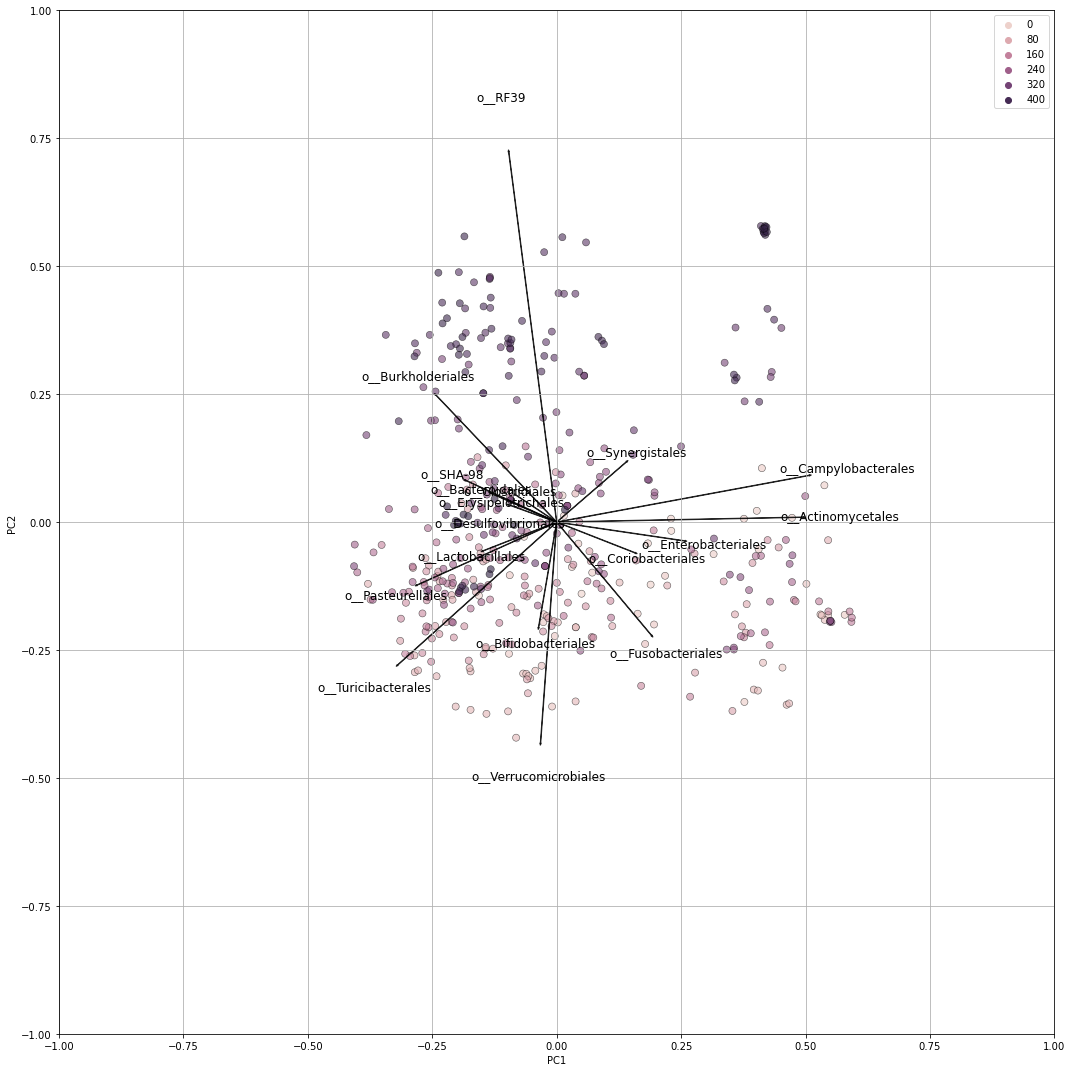

In [99]:
# PCA ON CLR RATIOS
plot_pca(CLR_DF, CLR_DF.columns)

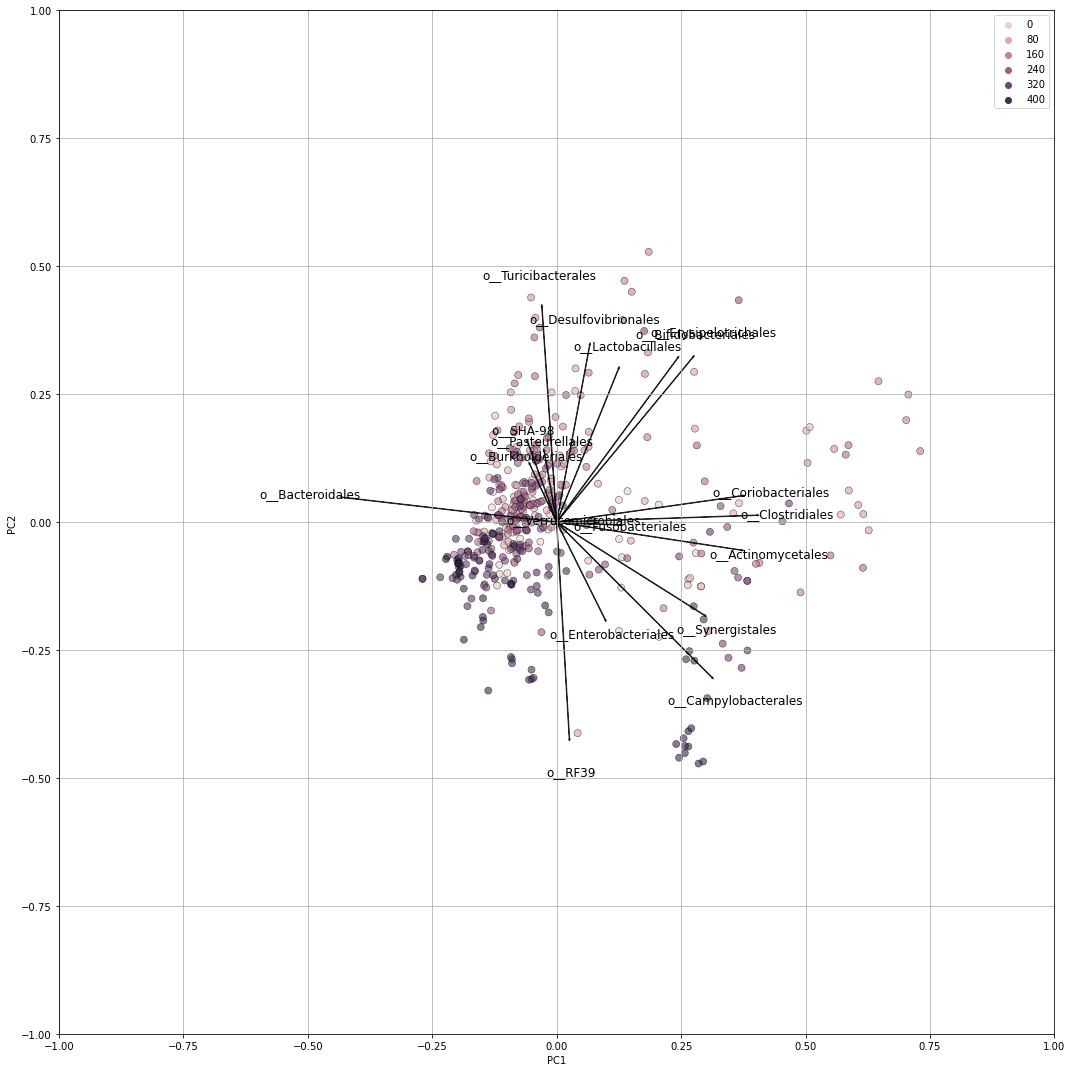

In [98]:
#PCA ON RAW COUNTS
scaler = StandardScaler()
scaled_x = scaler.fit_transform(df_filtered_order)
plot_pca(scaled_x, df_filtered_order.columns)

## DISTANCE MATRIX 

In [103]:
def plot_distance_matrix(df, metric = 'braycurtis'):
    
    distance_matrix = squareform(pdist(df, metric = 'braycurtis'))

    plt.figure(figsize = [15, 15])
    matrix = np.triu(distance_matrix)
    sns.heatmap(distance_matrix, cmap = 'Blues', linewidth=.1)#, mask=matrix)
    plt.show()

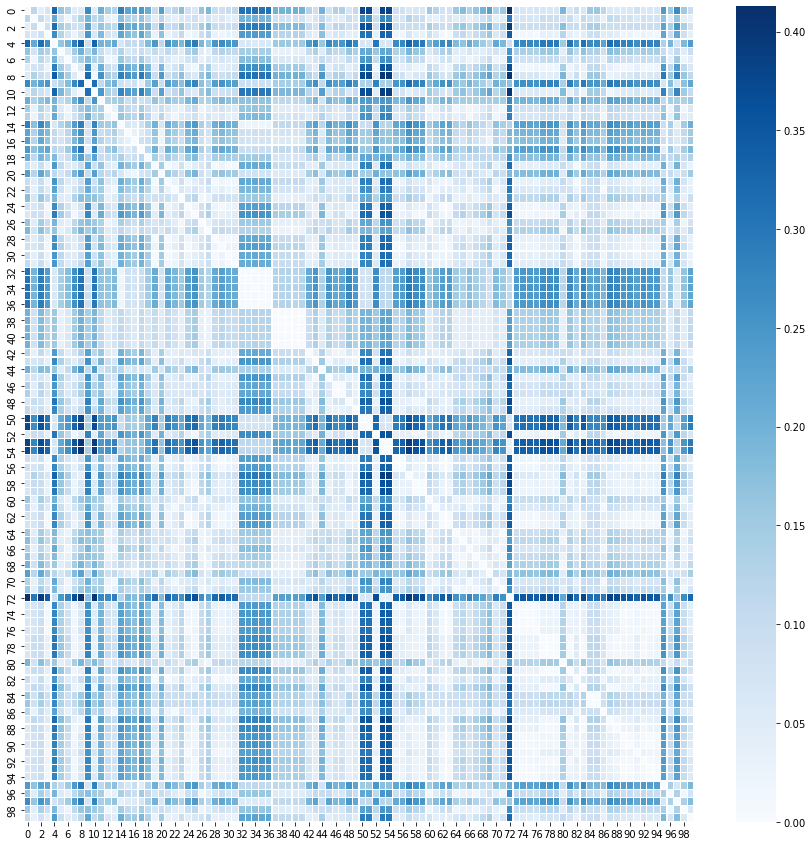

In [109]:
#RAW COUNTS
plot_distance_matrix(df_filtered_order.iloc[:100], 'euclidean')

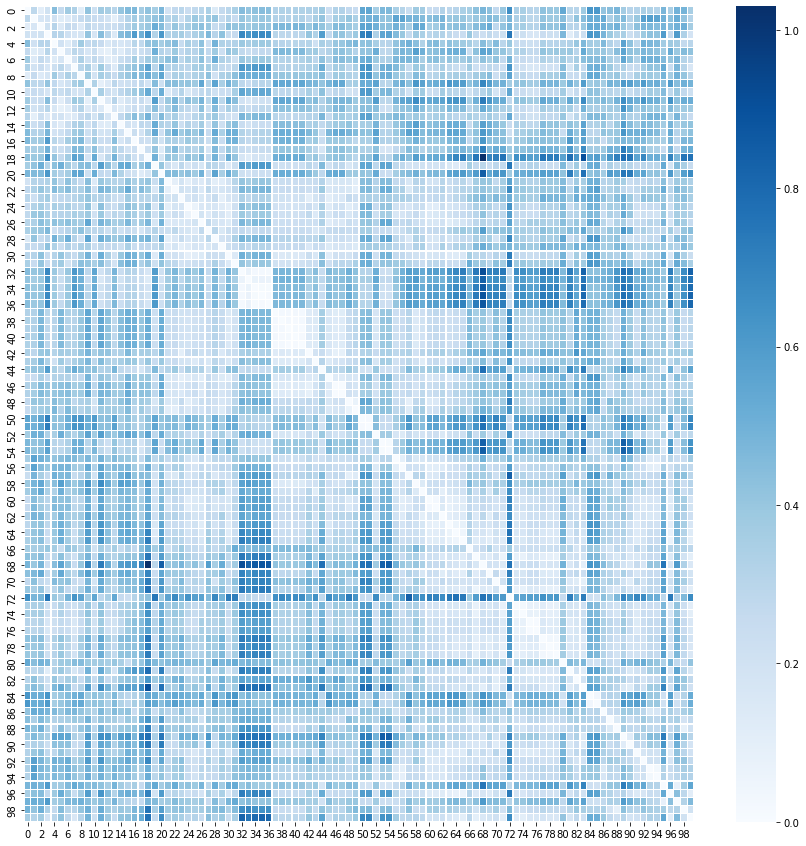

In [108]:
#CLR RATIOS
plot_distance_matrix(CLR_DF.iloc[:100], 'euclidean')

## CLUSTERING

In [77]:
def plot_clustering(df, metric, transformation):
    
    n_clusters = 4
    
    if metric == 'braycurtis':
        
        distance_matrix = squareform(pdist(df, metric = metric))

        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage = 'complete')
        clustering_model.fit(distance_matrix)
        cluster_labels = clustering_model.labels_
        
    elif metric == 'euclidean':
    

        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
        clustering_model.fit(df)
        cluster_labels = clustering_model.labels_


    pca = PCA()
    x_new = pca.fit_transform(df.values)
    score = x_new[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])
    cluster_labels = cluster_labels
    labels = df.columns

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig = plt.figure(figsize=(15, 15))

    sns.scatterplot(x = xs * scalex, y = ys * scaley, alpha = .7, color = 'orange', edgecolor = 'white', hue = cluster_labels, s=100, palette = 'Set2')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize = 14)

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

    plt.tight_layout()
    plt.savefig('agglomerative_clustering_{}_distance_{}.png'.format(metric, transformation))
    plt.show()

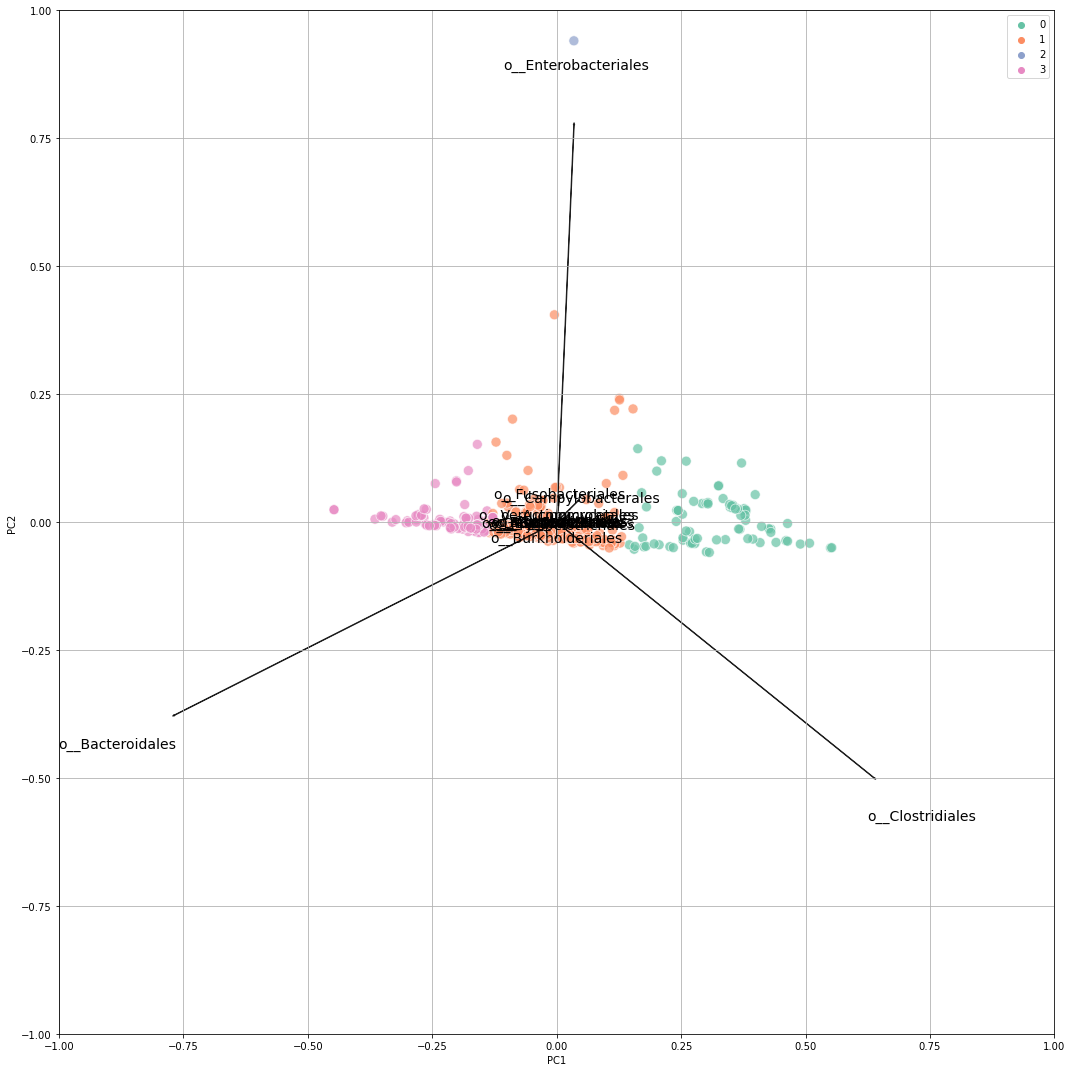

In [80]:
#RAW COUNTS
plot_clustering(df_filtered_order, 'euclidean', 'count')

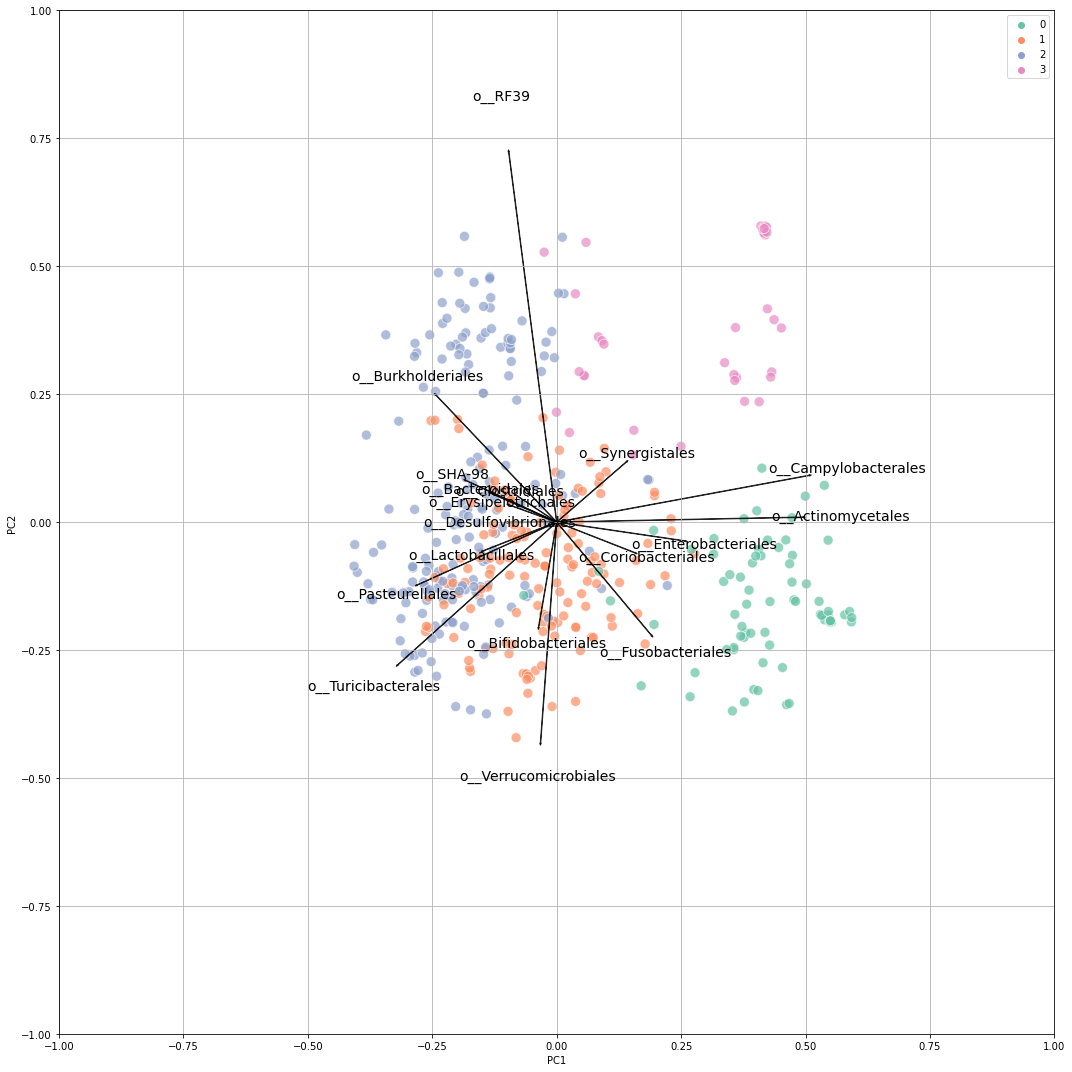

In [81]:
#CLR RATIOS
plot_clustering(CLR_DF, 'euclidean', 'clr')